In [8]:
from functions import sample_uniform_parameters, sample_correlated_parameters, output_from_parameters, output_from_parameters_with_noise, obtain_theta, perform_CNLS_LASSO, obtain_beta_unique, add_random_variables, add_random_correlated_variables, delete_random_variables, retrieve_results, retrieve_results_regular_lasso
from pystoned.plot import plot2d
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
import copy

### Sample the true parameters X (iid vs. Correlated), and create Y
### Obtain theta from the results

In [9]:
# CORRELATION FOR TRUE INPUTS
# Fill in the desired correlations between the variables in the dictionary corrs
nr_of_corr_variables = 5

corrs_TRUE = {i: {} for i in range(0, nr_of_corr_variables+1)}
corrs_FALSE = {i: {} for i in range(0, nr_of_corr_variables+1)}

corrs_TRUE[1][2] = 0.8

# CORRELATION FOR FALSE INPUTS
corrs_FALSE[1][2] = 0.8
corrs_FALSE[1][3] = 0.8
corrs_FALSE[2][3] = 0.8
corrs_FALSE[4][5] = 0.8
corrs_FALSE[6][7] = 0.8


In [44]:
CORRELATION = False
CORRELATION_REDUNDANT_VARIABLES = False
SEED = 44
TRUE_INPUTS = 2
REDUNDANT_INPUTS = 7
NR_DMU = 100

if CORRELATION:
    x = sample_correlated_parameters(i=TRUE_INPUTS,k=NR_DMU, rho_dict=corrs_TRUE, min_value=10, max_value=20, seed=SEED)
else:
    x = sample_uniform_parameters(i=TRUE_INPUTS,k=NR_DMU, min_value=10, max_value=20, seed=SEED)

y_log_true = output_from_parameters(x, cons = 3)
y_log = output_from_parameters_with_noise(x, cons=3, var=0.7)

if CORRELATION_REDUNDANT_VARIABLES:
    x = add_random_correlated_variables(x, REDUNDANT_INPUTS, corrs_FALSE, min_value = 10, max_value = 20, seed=SEED+1)
else:
    x = add_random_variables(x, REDUNDANT_INPUTS, min_value = 10, max_value = 20, seed=SEED+1)

model_cnls = perform_CNLS_LASSO(x=x, y=y_log, eta=1)
beta = model_cnls.get_beta()
alpha = model_cnls.get_alpha()
beta = pd.DataFrame(beta).round(2)
beta.loc['Total',:] = beta.sum(axis=0)
SSR_model = (model_cnls.get_residual()**2).sum()
MSE_model = (model_cnls.get_residual()**2).mean()
nr_variables_deleted = (beta.loc['Total',:] == 0).sum()
nr_correct_variables_deleted = (beta.loc['Total',[0,1]] == 0).sum()
display(beta)

Estimating the additive model remotely with mosek solver.


,0,1,2,3,4,5,6,7,8
0,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00
1,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00
2,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00
3,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00
4,0.00,0.0,0.00,0.0,0.01,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...
96,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
97,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
98,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00
99,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00


In [ ]:
theta = obtain_theta(x, y_log_true)

### Perform the SCNLS-LASSO regression

In [36]:
model_cnls = perform_CNLS_LASSO(x=x, y=y_log, eta=0.001)
beta = model_cnls.get_beta()
alpha = model_cnls.get_alpha()
beta = pd.DataFrame(beta).round(3)
beta.loc['Total',:] = beta.sum(axis=0)
SSR_model = (model_cnls.get_residual()**2).sum()
MSE_model = (model_cnls.get_residual()**2).mean()
nr_variables_deleted = (beta.loc['Total',:] == 0).sum()
nr_correct_variables_deleted = (beta.loc['Total',[0,1]] == 0).sum()
display(beta)
# beta_unique = obtain_beta_unique(x, alpha, beta).T.round(2).rename(columns={0:'Alpha'})
# beta_unique.loc['Total',:] = beta_unique.sum(axis=0)
# display(beta_unique)
# plot2d(model_cnls, x_select=0, label_name="CNLS", fig_name='CNLS_frontier')

Estimating the additive model remotely with mosek solver.


,0,1,2,3,4,5,6,7,8
0,0.000,0.000,0.000,0.012,0.000,0.000,0.00,0.000,0.017
1,0.000,0.000,0.000,0.000,0.000,0.029,0.00,0.000,0.000
2,0.000,0.001,0.009,0.001,0.000,0.012,0.00,0.007,0.000
3,0.000,0.000,0.007,0.000,0.000,0.010,0.00,0.022,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.014,0.016
5,0.000,0.000,0.000,0.000,0.000,0.018,0.00,0.011,0.000
6,0.022,0.000,0.000,0.000,0.000,0.000,0.01,0.000,0.000
7,0.013,0.003,0.000,0.000,0.020,0.002,0.00,0.000,0.000
8,0.000,0.022,0.000,0.000,0.000,0.000,0.00,0.000,0.006
9,0.027,0.001,0.002,0.000,0.000,0.000,0.00,0.000,0.000


In [28]:
SSR_model = (model_cnls.get_residual()**2).sum()
MSE_model = (model_cnls.get_residual()**2).mean()

In [29]:
SSR_model

3.962526248534638

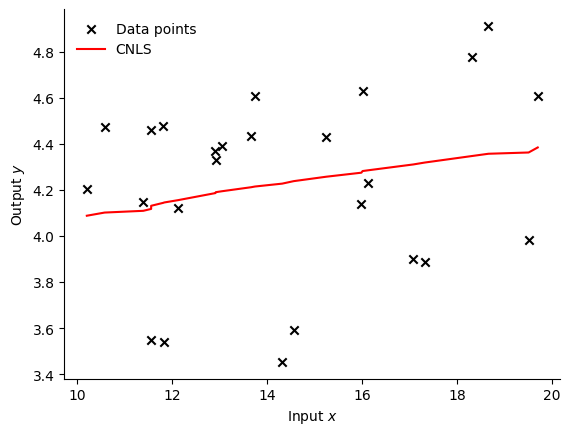

In [37]:
plot2d(model_cnls, x_select=0, label_name="CNLS", fig_name='CNLS_frontier')

## Results SCNLS-LASSO Variable Selection; 500 repetitions, DMUs=25, 2 True inputs, 7 False inputs

In [48]:
CORRELATION = False
CORRELATION_REDUNDANT_VARIABLES = False
SEED = 42
TRUE_INPUTS = 2
REDUNDANT_INPUTS = 7
NR_DMU = 25

result_dict = {'SSR':{}, 'MSE':{}, 'nr_variables_deleted':{}, 'nr_correct_variables_deleted':{}}

for run in range(0,500):
    SEED = run
    if CORRELATION:
        x = sample_correlated_parameters(i=TRUE_INPUTS,k=NR_DMU, rho_dict=corrs_TRUE, min_value=10, max_value=20, seed=SEED)
    else:
        x = sample_uniform_parameters(i=TRUE_INPUTS,k=NR_DMU, min_value=10, max_value=20, seed=SEED)

    y_log_true = output_from_parameters(x, cons = 3)
    y_log = output_from_parameters_with_noise(x, cons=3, var=0.1)

    if CORRELATION_REDUNDANT_VARIABLES:
        x = add_random_correlated_variables(x, REDUNDANT_INPUTS, corrs_FALSE, min_value = 10, max_value = 20, seed=SEED+1)
    else:
        x = add_random_variables(x, REDUNDANT_INPUTS, min_value = 10, max_value = 20, seed=SEED+1)


    model_cnls = perform_CNLS_LASSO(x=x, y=y_log, eta=0.01)
    beta = model_cnls.get_beta()
    alpha = model_cnls.get_alpha()
    beta = pd.DataFrame(beta).round(3)
    beta.loc['Total',:] = beta.sum(axis=0)
    result_dict['SSR'][run] = SSR_model = (model_cnls.get_residual()**2).sum()
    result_dict['MSE'][run] = MSE_model = (model_cnls.get_residual()**2).mean()
    result_dict['nr_variables_deleted'][run] = nr_variables_deleted = (beta.loc['Total',:] == 0).sum()
    result_dict['nr_correct_variables_deleted'][run] = nr_correct_variables_deleted = (beta.loc['Total',[0,1]] == 0).sum()

results = pd.DataFrame(result_dict)
results.to_csv('results_SCNLS_LASSO_2_true_7_false_25_dmu_not_sorted_0_1_var_eta_0_01_CORR.csv', sep = ';')


Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the

In [ ]:
results.describe()

## Results Random Variable Selection; ""

In [ ]:
CORRELATION = False
CORRELATION_REDUNDANT_VARIABLES = False
SEED = 42
TRUE_INPUTS = 2
REDUNDANT_INPUTS = 7
NR_DMU = 25

result_dict_random = {'nr_variables_deleted':{}, 'nr_true_variables_deleted':{}}
for i in range(0,500):
    SEED = i
    x = sample_uniform_parameters(i=TRUE_INPUTS,k=NR_DMU, min_value=10, max_value=20, seed=SEED)
    x = add_random_variables(x, REDUNDANT_INPUTS, min_value = 10, max_value = 20, seed=SEED+1)
    x, nr_deletions, nr_true_variables_deleted = delete_random_variables(x, seed=SEED+2)
    result_dict_random['nr_variables_deleted'][i] = nr_variables_deleted = nr_deletions
    result_dict_random['nr_true_variables_deleted'][i] = nr_true_variables_deleted

results_random = pd.DataFrame(result_dict_random)
results_random.to_csv('results_random_2_true_7_false_25_dmu.csv', sep = ';')
results_random.describe()

## Calculating the MSEs of the LASSO, SCNLS-LASSO and RANDOM; 100 DMUs, 30 reps

In [ ]:
CORRELATION = False
CORRELATION_REDUNDANT_VARIABLES = False
TRUE_INPUTS = 2
REDUNDANT_INPUTS = 7
NR_DMU = 100
def perform_grid_search_reg_LASSO(alphas=np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]), reps=30):
    #import packages
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV

    #create grid search
    grid_search = GridSearchCV(estimator=Lasso(), param_grid={'alpha':alphas}, cv=5, scoring='neg_mean_squared_error')

    #run grid search for each dataset and store results
    all_results = []

    for run in range(0,reps):
        SEED = run
        if CORRELATION:
            x = sample_correlated_parameters(i=TRUE_INPUTS,k=NR_DMU, rho_dict=corrs_TRUE, min_value=10, max_value=20, seed=SEED)
        else:
            x = sample_uniform_parameters(i=TRUE_INPUTS,k=NR_DMU, min_value=10, max_value=20, seed=SEED)

        y_log = output_from_parameters_with_noise(x, cons=3, var=0.1)

        if CORRELATION_REDUNDANT_VARIABLES:
            x = add_random_correlated_variables(x, REDUNDANT_INPUTS, corrs_FALSE, min_value = 10, max_value = 20, seed=SEED+1)
        else:
            x = add_random_variables(x, REDUNDANT_INPUTS, min_value = 10, max_value = 20, seed=SEED+1)
        
        grid_search.fit(np.log(x).T, y_log.T)
        all_results.append(grid_search.best_params_['alpha'])

    #calculate average alpha
    average_alpha = np.mean(all_results)
    return average_alpha

In [49]:
results_SCNLS_LASSO = {}
results_random = {}
results_reg_LASSO = {}

eta_reg_LASSO = perform_grid_search_reg_LASSO()


CORRELATION = False
CORRELATION_REDUNDANT_VARIABLES = False
TRUE_INPUTS = 2
REDUNDANT_INPUTS = 7
NR_DMU = 100

for i in range(1,10):
    results_SCNLS_LASSO_run = {'SSR':{}, 'MSE':{}, 'nr_variables_deleted':{}, 'nr_correct_variables_deleted':{}}
    results_random_run = {'SSR':{}, 'MSE':{}, 'nr_variables_deleted':{}, 'nr_correct_variables_deleted':{}}
    results_reg_LASSO_run = {'SSR':{}, 'MSE':{}, 'nr_variables_deleted':{}, 'nr_correct_variables_deleted':{}}
    print(i)
    if i >2:
        TRUE_INPUTS = 2
        REDUNDANT_INPUTS = i-2
    else:
        TRUE_INPUTS = i
        REDUNDANT_INPUTS = 0

    for run in range(0,30):
        SEED = run
        if CORRELATION:
            x = sample_correlated_parameters(i=TRUE_INPUTS,k=NR_DMU, rho_dict=corrs_TRUE, min_value=10, max_value=20, seed=SEED)
        else:
            x = sample_uniform_parameters(i=TRUE_INPUTS,k=NR_DMU, min_value=10, max_value=20, seed=SEED)

        y_log_true = output_from_parameters(x, cons = 3)
        y_log = output_from_parameters_with_noise(x, cons=3, var=0.1)

        if CORRELATION_REDUNDANT_VARIABLES:
            x = add_random_correlated_variables(x, REDUNDANT_INPUTS, corrs_FALSE, min_value = 10, max_value = 20, seed=SEED+1)
        else:
            x = add_random_variables(x, REDUNDANT_INPUTS, min_value = 10, max_value = 20, seed=SEED+1)
        
        x_random, nr_random_deletions, nr_random_true_variables_deleted = delete_random_variables(x, seed=SEED+2)

        # SCNLS-LASSO
        model_scnls_lasso = perform_CNLS_LASSO(x=x, y=y_log, eta=1)
        ssr, mse, nr_variables_deleted_lasso, nr_correct_variables_deleted_lasso = retrieve_results(model_scnls_lasso)
        results_SCNLS_LASSO_run['SSR'][run] = ssr
        results_SCNLS_LASSO_run['MSE'][run] = mse
        results_SCNLS_LASSO_run['nr_variables_deleted'][run] = nr_variables_deleted_lasso
        results_SCNLS_LASSO_run['nr_correct_variables_deleted'][run] = nr_correct_variables_deleted_lasso

        # Random deletion
        model_random = perform_CNLS_LASSO(x=x_random, y=y_log, eta=0)
        ssr, mse, _, _ = retrieve_results(model_scnls_lasso)
        results_random_run['SSR'][run] = ssr
        results_random_run['MSE'][run] = mse
        results_random_run['nr_variables_deleted'][run] = nr_random_deletions
        results_random_run['nr_correct_variables_deleted'][run] = nr_random_true_variables_deleted


        # Regular LASSO
        lasso_model = Lasso(alpha=eta_reg_LASSO)
        lasso_model.fit(np.log(x).T, y_log.T)
        ssr, mse, nr_variables_deleted_reg_lasso, nr_correct_variables_deleted_reg_lasso = retrieve_results_regular_lasso(lasso_model, x, y_log)
        results_reg_LASSO_run['SSR'][run] = ssr
        results_reg_LASSO_run['MSE'][run] = mse
        results_reg_LASSO_run['nr_variables_deleted'][run] = nr_variables_deleted_reg_lasso
        results_reg_LASSO_run['nr_correct_variables_deleted'][run] = nr_correct_variables_deleted_reg_lasso
        
    results_SCNLS_LASSO[i] = results_SCNLS_LASSO_run
    results_random[i] = results_random_run
    results_reg_LASSO[i] = results_reg_LASSO_run

results_SCNLS_df =pd.DataFrame()
results_random_df =pd.DataFrame()
results_reg_LASSO_df =pd.DataFrame()


for i in range(1,10):

    results_SCNLS_df_i = pd.DataFrame(results_SCNLS_LASSO[i]).rename(columns = lambda x: x+f'_{i}')
    results_SCNLS_df = pd.concat([results_SCNLS_df, results_SCNLS_df_i], axis=1)
    results_random_i = pd.DataFrame(results_random[i]).rename(columns = lambda x: x+f'_{i}')
    results_random_df = pd.concat([results_random_df, results_random_i], axis=1)
    results_reg_LASSO_i = pd.DataFrame(results_reg_LASSO[i]).rename(columns = lambda x: x+f'_{i}')
    results_reg_LASSO_df = pd.concat([results_reg_LASSO_df, results_reg_LASSO_i], axis=1)

results_SCNLS_df.to_csv('results_SCNLS_df_100_dmus_30_reps_eta_1_notsorted_var_0_1_CORR.csv')
results_random_df.to_csv('results_random_df_100_dmus_30_reps_eta_1_notsorted_var_0_1_CORR.csv')
results_reg_LASSO_df.to_csv('results_reg_LASSO_df_100_dmus_30_reps_eta_1_notsorted_var_0_1_CORR.csv')
    

1
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating the additive model remotely with mosek solver.
Estimating t

In [ ]:
Avg_SCNLS_LASSO = pd.DataFrame(pd.DataFrame(results_SCNLS_LASSO[i]).mean() for i in range(1,10))
Avg_random = pd.DataFrame(pd.DataFrame(results_random[i]).mean() for i in range(1,10))
Avg_reg_LASSO = pd.DataFrame(pd.DataFrame(results_reg_LASSO[i]).mean() for i in range(1,10))


display(Avg_SCNLS_LASSO)
display(Avg_random)
display(Avg_reg_LASSO)

In [ ]:
results_SCNLS_df =pd.DataFrame()
results_random_df =pd.DataFrame()
results_reg_LASSO_df =pd.DataFrame()


for i in range(1,10):

    results_SCNLS_df_i = pd.DataFrame(results_SCNLS_LASSO[i]).rename(columns = lambda x: x+f'_{i}')
    results_SCNLS_df = pd.concat([results_SCNLS_df, results_SCNLS_df_i], axis=1)
    results_random_i = pd.DataFrame(results_random[i]).rename(columns = lambda x: x+f'_{i}')
    results_random_df = pd.concat([results_random_df, results_random_i], axis=1)
    results_reg_LASSO_i = pd.DataFrame(results_reg_LASSO[i]).rename(columns = lambda x: x+f'_{i}')
    results_reg_LASSO_df = pd.concat([results_reg_LASSO_df, results_reg_LASSO_i], axis=1)

results_SCNLS_df.to_csv('results_SCNLS_df_100_dmus_30_reps_eta_1_notsorted_var_0_7.csv')
results_random_df.to_csv('results_random_df_100_dmus_30_reps_eta_1_notsorted_var_0_77.csv')
results_reg_LASSO_df.to_csv('results_reg_LASSO_df_100_dmus_30_reps_eta_1_notsorted_var_0_7.csv')